# TP1 – Analyse des données (IFT599 / IFT799)

**Auteurs :**  
-  
-  
-  3

**Date de remise :** 03 octobre 2025  


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

## Charger tous les jeux de données

In [3]:
# Load transaction data
transactions = pd.read_csv("data/transactions_data.csv")

# Load card information
cards = pd.read_csv("data/cards_data.csv")

# Load user information
users = pd.read_csv("data/users_data.csv")

# Load mcc codes information
with open("data/mcc_codes.json", "r") as f:
    mcc_data = json.load(f)

mcc_codes = pd.DataFrame(list(mcc_data.items()), columns=["code", "description"])

# Load fraud information
with open("data/train_fraud_labels.json", "r") as f:
    fraud_data = json.load(f)

# Extract the inner dictionary
fraud_dict = fraud_data['target']

# Convert to DataFrame
fraud_labels = pd.DataFrame(list(fraud_dict.items()), columns=["transaction_id", "is_fraud"])

# 3.1 Préparation des données (25%)

## 1. Fusion des différents fichiers (`transactions`, `cards`, `users`, `mcc`, `fraud`)  
  - Clés de jointure utilisées  
  - Vérifier lees colonnes dupliquées et suffixes `_x`, `_y`  (causés par pandas)
  - Expliquer les choix 

In [4]:
# Rename keys before merging
transactions = transactions.rename(columns={"id": "transaction_id"})
cards = cards.rename(columns={"id": "card_id"})
users = users.rename(columns={"id": "user_id"})
mcc_codes = mcc_codes.rename(columns={"code": "mcc_code", "description": "mcc_description"})

In [5]:
# Ensure same dtype for transaction_id
transactions["transaction_id"] = transactions["transaction_id"].astype(str)
fraud_labels["transaction_id"] = fraud_labels["transaction_id"].astype(str)

# Ensure same dtype for mcc
transactions["mcc"] = transactions["mcc"].astype(str)
mcc_codes["mcc_code"] = mcc_codes["mcc_code"].astype(str)

In [6]:
merged_df = (
    transactions
    .merge(cards, on="card_id", how="left", suffixes=("", "_card"))
    .merge(users, left_on="client_id", right_on="user_id", how="left", suffixes=("", "_user"))
    .merge(mcc_codes, left_on="mcc", right_on="mcc_code", how="left")
    .merge(fraud_labels, on="transaction_id", how="left")
)

merged_df.head()

,transaction_id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,mcc_code,mcc_description,is_fraud
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,...,46.80,-100.76,$23679,$48277,$110153,740,4,5499,Miscellaneous Food Stores,No
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,...,40.80,-91.12,$18076,$36853,$112139,834,5,5311,Department Stores,No
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,...,33.18,-117.29,$16894,$34449,$36540,686,3,4829,Money Transfer,No
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,...,41.42,-87.35,$26168,$53350,$128676,685,5,4829,Money Transfer,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,...,38.86,-76.60,$33529,$68362,$96182,711,2,5813,Drinking Places (Alcoholic Beverages),No


## 2. Identification des variables peu pertinentes  
  - Liste des variables exclues  
  - Justifications (faible variance, redondance, trop de valeurs manquantes, etc.)(liste dans le pdf)  
  - Visualisations ou statistiques descriptives à l’appui  (généralement boxplot)

In [7]:
# Check variance for numeric features
low_variance = merged_df.var(numeric_only=True).sort_values()
print(low_variance)

# Look at categorical features' unique values
for col in merged_df.select_dtypes(include=['object']).columns:
    print(col, merged_df[col].nunique())

num_cards_issued         2.654476e-01
num_credit_cards         2.458112e+00
year_pin_last_changed    8.379903e+00
retirement_age           1.286465e+01
birth_month              1.299606e+01
latitude                 2.592665e+01
birth_year               2.470101e+02
current_age              2.473543e+02
longitude                2.644312e+02
credit_score             4.329996e+03
cvv                      8.327915e+04
client_id                3.383034e+05
client_id_card           3.383034e+05
user_id                  3.383034e+05
card_id                  2.803468e+06
merchant_id              6.664317e+08
zip                      8.646085e+08
card_number              1.720131e+30
dtype: float64
transaction_id 13305915
date 4136496
amount 81161
use_chip 3
merchant_city 12492
merchant_state 199
mcc 109
errors 22
card_brand 4
card_type 3
expires 180
has_chip 2
credit_limit 2603
acct_open_date 295
card_on_dark_web 1
gender 2
address 1219
per_capita_income 1120
yearly_income 1201
total_debt 1150

**Candidate variables to drop based on low variance / redundancy:**

Drop:
- IDs / unique identifiers:   transaction_id, client_id, card_id, user_id, client_id_card, card_number, merchant_id, zip
- No behavioral meaning:   cvv

Consider dropping:
- Redundant: One of (birth_year, current_age)
- Not directly linked to transaction patterns: retirement_age
- latitude/longitude

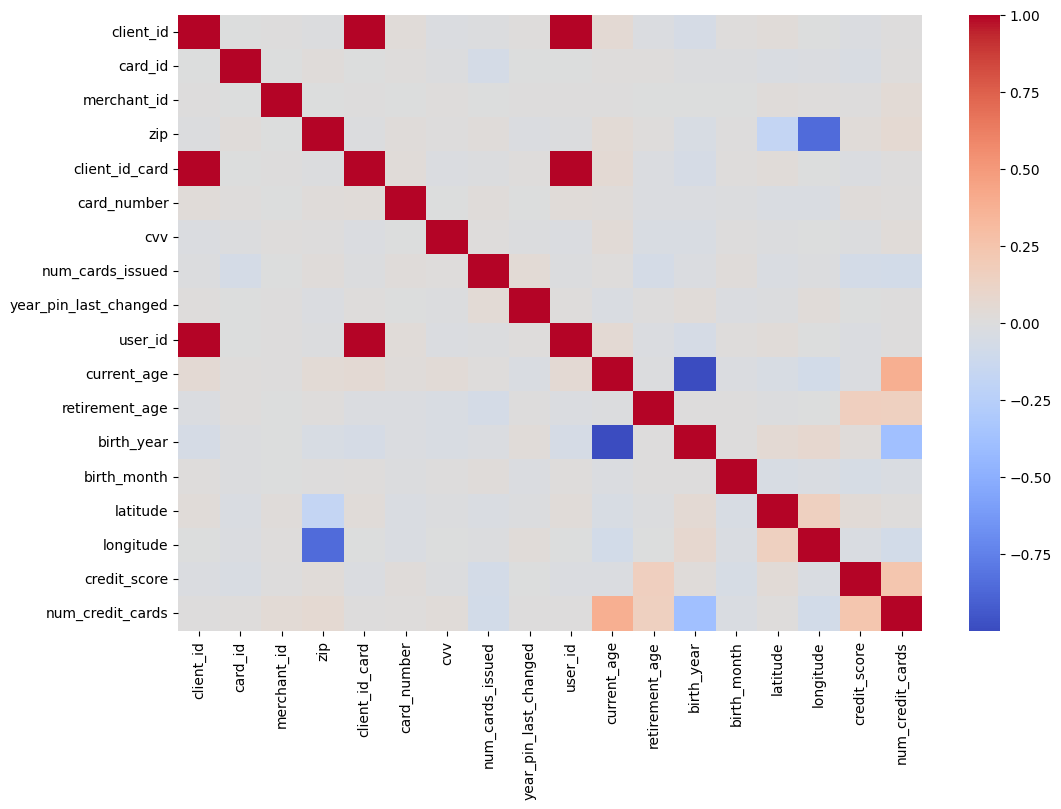

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = merged_df.corr(numeric_only=True)

# Plot a heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0)
plt.show()

**Correlation**

Drop:
- Duplicates of each other: client_id, client_id_card, user_id
- Either birth_year or current_age
- Pick one representation for location: either zip or (latitude + longitude)

**Missing values**

Drop:
- errors (98% missing, unusable)

## 3. Nettoyage des données
  
**Valeurs manquantes**  
  - Doublons  
  - Types de données  
  - Incohérences  

errors                   0.984113
is_fraud                 0.330000
zip                      0.124208
merchant_state           0.117519
transaction_id           0.000000
amount                   0.000000
date                     0.000000
card_id                  0.000000
client_id                0.000000
merchant_city            0.000000
merchant_id              0.000000
use_chip                 0.000000
mcc                      0.000000
card_brand               0.000000
card_type                0.000000
card_number              0.000000
client_id_card           0.000000
cvv                      0.000000
has_chip                 0.000000
num_cards_issued         0.000000
credit_limit             0.000000
acct_open_date           0.000000
year_pin_last_changed    0.000000
card_on_dark_web         0.000000
expires                  0.000000
user_id                  0.000000
current_age              0.000000
birth_year               0.000000
retirement_age           0.000000
gender        

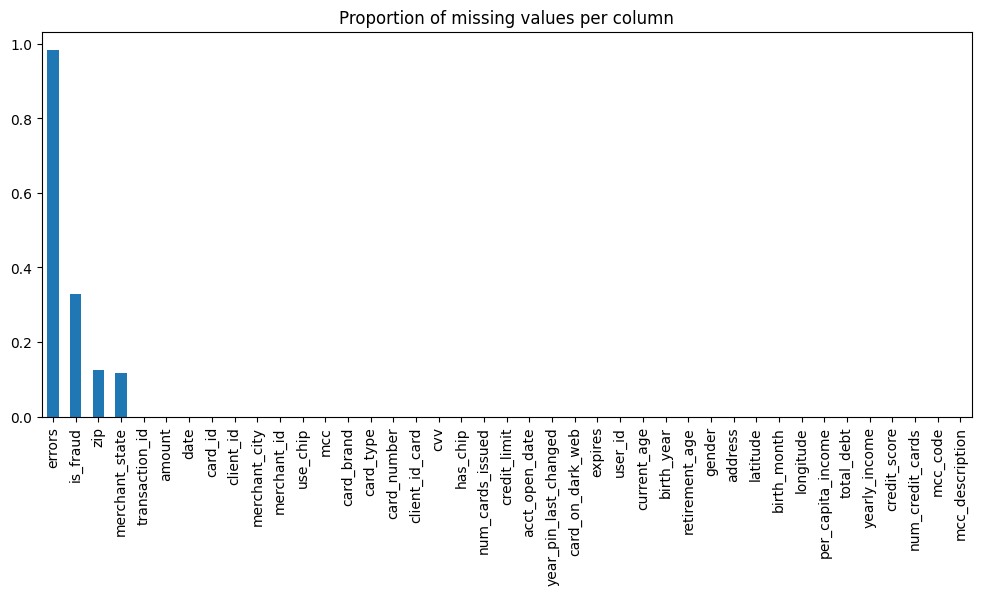

In [9]:
# Check missing values
missing = merged_df.isnull().mean().sort_values(ascending=False)
print(missing)

# Visualize
missing.plot(kind="bar", figsize=(12,5), title="Proportion of missing values per column")
plt.show()

**Doublons**

In [11]:
# Count fully duplicated rows
dup_rows = merged_df.duplicated().sum()
print(f"Number of completely duplicated rows: {dup_rows}")

# If you find any, drop them
merged_df = merged_df.drop_duplicates()

Number of completely duplicated rows: 0


In [12]:
# Check if any transaction_id is duplicated
dup_trans = merged_df["transaction_id"].duplicated().sum()
print(f"Number of duplicated transaction_id: {dup_trans}")

# If you find any, keep only the first occurrence
merged_df = merged_df.drop_duplicates(subset=["transaction_id"], keep="first")

Number of duplicated transaction_id: 0


In [13]:
# How many unique transactions per card_id / client_id?
print(merged_df.groupby("card_id")["transaction_id"].nunique().head())
print(merged_df.groupby("client_id")["transaction_id"].nunique().head())

card_id
0    3402
1    2841
2    8028
3    2870
4     890
Name: transaction_id, dtype: int64
client_id
0    12795
1    10073
2    10612
3     6001
4    15043
Name: transaction_id, dtype: int64


**Types de données**
- Transaction amounts: Remove `$`, convert to float, then check stats.

In [19]:
# List of columns that contain dollar amounts
money_cols = ["amount", "per_capita_income", "yearly_income", "total_debt"]

# Remove $ and commas, convert to float
for col in money_cols:
    merged_df[col] = (merged_df[col].replace('[\$,]', '', regex=True).astype(float))


<>:6: SyntaxWarning: invalid escape sequence '\$'
<>:6: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_484502/1381650976.py:6: SyntaxWarning: invalid escape sequence '\$'
  merged_df[col] = (merged_df[col].replace('[\$,]', '', regex=True).astype(float))


In [20]:
merged_df.head()

,transaction_id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,mcc_code,mcc_description,is_fraud
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,...,46.80,-100.76,23679.0,48277.0,110153.0,740,4,5499,Miscellaneous Food Stores,No
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,...,40.80,-91.12,18076.0,36853.0,112139.0,834,5,5311,Department Stores,No
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,...,33.18,-117.29,16894.0,34449.0,36540.0,686,3,4829,Money Transfer,No
3,7475331,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,...,41.42,-87.35,26168.0,53350.0,128676.0,685,5,4829,Money Transfer,NaN
4,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,...,38.86,-76.60,33529.0,68362.0,96182.0,711,2,5813,Drinking Places (Alcoholic Beverages),No


- Date format: Convert to datetime and check ordering.

In [16]:
merged_df["date"] = pd.to_datetime(merged_df["date"], errors="coerce")

# Check if any failed conversion (become NaT)
print("Invalid dates:", merged_df["date"].isna().sum())

Invalid dates: 0


In [17]:
# Check typos or inconsistent formatting.
print("Unique use_chip values:", merged_df["use_chip"].unique())
print("Unique fraud labels:", merged_df["is_fraud"].unique())
print("Unique state codes:", merged_df["merchant_state"].nunique())

Unique use_chip values: ['Swipe Transaction' 'Online Transaction' 'Chip Transaction']
Unique fraud labels: ['No' nan 'Yes']
Unique state codes: 199


In [18]:
# Check how many codes map to multiple descriptions
mcc_check = merged_df.groupby("mcc_code")["mcc_description"].nunique()
print("MCC codes with >1 description:\n", mcc_check[mcc_check > 1])

MCC codes with >1 description:
 Series([], Name: mcc_description, dtype: int64)


## 4. Création de variables dérivées  
  - Heure de transaction  
  - Jour de la semaine  
  - Montant normalisé  
  - Intervalle entre deux transactions  
  - Autres pertinentes  

In [21]:
# Find patterns and trends by looking at transaction' hour, day and month
merged_df["transaction_hour"] = merged_df["date"].dt.hour
merged_df["transaction_day"] = merged_df["date"].dt.dayofweek  # 0=Mon, 6=Sun
merged_df["transaction_month"] = merged_df["date"].dt.month

In [22]:
# Scale the amount relative to the client’s yearly income
merged_df["amount_to_income"] = merged_df["amount"] / merged_df["yearly_income"].replace(0, np.nan)

In [23]:
# For each client_id, compute the time difference between consecutive transactions
merged_df = merged_df.sort_values(["client_id", "date"])
merged_df["time_since_last_txn"] = merged_df.groupby("client_id")["date"].diff().dt.total_seconds()

**5. Visualisation exploratoire**  
  - Diagrammes en secteurs des top 10 commerçants (revenus & nombre de transactions)  
  - Visualisation des périodes de pointe  
  - Interprétation  

**6. Encodage des variables catégorielles**  
  - Codes MCC, types de cartes  
  - Méthodes d’encodage testées (Label vs One-hot)  
  - Justification des choix retenus 

# 3.2  Analyse d’association (20%)


- **1. Préparation des transactions pour Apriori / FP-Growth**  
  - Structure attendue   (apriori vs fp-growth)
  - Préparation des transactions pour être compatibles avec chacune

- **2.Extraction de règles d’association**  
  - Exemples concrets  
  - Patterns observés (habitudes de consommation, fidélité, etc.)

- **3. Codes MCC et types de commerces**  
  - Dépenses élevées  
  - Patterns comportementaux  


- **4. Associations types cartes ↔ commerçants**  
  - Profils d’utilisation  

- **5.Combinaisons liées aux fraudes**  
  - Montants élevés, heures tardives, types de commerçants


- **6. interprétation des métriques**  
  - Support, confiance, lift  
  - Visualisations des règles  

- **7. Choix des seuils (support, confiance)**  
  - Justification en fonction du volume et de l’objectif  

# 3.3 Analyse de séquences (15%)

- **Construction des séquences de transactions**  
  - Par client  
  - Variables d’ordre  (horodatage, type de commer¸cant, montant, etc.)?

- **Application d’algorithmes (PrefixSpan, SPADE, EMMA)**  
  - Parcours typiques identifiés  


- **Habitudes et routines**  
  - Parcours d’achat récurrents  (fréquences, routines ou habitudes récurrentes)


- **Patterns précurseurs de fraude**  
  - Petites transactions → retrait → fraude  
  - Interprétation  par motifs temporels ou comportementaux


- **Évolution du comportement client**  
  - Séquences avec contraintes temporelles 


- **Visualisations**  
  - Graphes de séquences fréquentes  
  - Aide à l’interprétation  

# 3.4 Recommandation sur les associations ou séquences (10%)

- **Objectif : proposer des items complémentaires**  
- **Méthodes testées :**  
  - Règles d’association fréquentes  
  - Séquences typiques  
  - Similarité entre transactions  
- **Implémentation d’un script Python autonome (`recommender.py`)**  
- **Exemple de recommandations générées**  

---

# 3.5 Analyse statistique comparative des classes (10%)

- **Comparaison fraude vs légitime**  
  - Scatter plots (2D, 3D)  
  - Réduction de dimension (ACP, t-SNE, UMAP)  
  - Regroupements et anomalies  


- **Approche univariée**  
  - Sélection de variables pertinentes  
  - Tests statistiques (t-test, Mann-Whitney, KS-test)  
  - Résultats comparés  


- **Approche multivariée**  
  - Hotelling, analyse discriminante linéaire  
  - Séparation des classes  
  - Visualisations complémentaires 

- **Discussion**  
  - Avantages, limites et implications  
  - Robustesse et pertinence des méthodes  

---

# 3.6 Pr´esentation des r´esultats (20%)


- Objectif de chaque méthode (bref rappel)  
- Démarche appliquée  
- Résultats obtenus  
- Commentaires et interprétations  
- Visualisations pertinentes  
- Citations des sources utilisées (obligatoires)  